# FACE DETECTION EXERCISE

The goal is to detect faces in images, in order to develop a face detection system to be implemented in a consumer camera, using a sklearn pipeline and not using a pre-trained model. The detection should also work with low computing resources.

A fundamental source for the completion of this notebook is *"Python Data Science Handbook"* by Jake VanderPlas.
Please find the relevant excerpt at this link: https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html
As suggested, there are different feature extraction methods for images. The one mentioned in the excerpt and used in this notebook is the *"Histogram of Oriented Gradients" (HOG)*, which transforms pixels into a vector representation. (https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)

Thanks to this method, I am able to train a classification model with satisfying performances in recognizing an image as a face or not, **without using pre-trained models**.

The model is then used in order to compare slices of a given image and tell if the slice contains a face or not.

The slices with faces (if any), are then processed in a non parametric clustering model, in order to assign them to the relative person.

Eventually, the up-left corner coordinates of the slice with the highest negative predicted probability is returned along with its cluster class and probability in a list.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage import data, color, feature
import skimage.data
from PIL import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import DBSCAN

In [4]:
def bw_img_wiev_with_hog (image, bw=True):
    """
    Prints a gray-scale image with its HOG. If the given image is not gray-scale specify bw=False
    Function based on notebook https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html
    """
    
    if bw == False:
        image = color.rgb2gray(image)
    
    hog_vec, hog_vis = feature.hog(image, visualize=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('input image')
    
    ax[1].imshow(hog_vis)
    ax[1].set_title('visualization of HOG features')

### The Model

**Importing positive samples - The faces**

In order to create a dataset, I import the useful *"The Labeled Faces in the Wild face recognition"* dataset, provided by sklearn.
https://scikit-learn.org/0.19/datasets/labeled_faces.html

In [7]:
from sklearn.datasets import fetch_lfw_people

faces_lfw_people = fetch_lfw_people(resize=0.25, slice_=(slice(61, 189), slice(61, 189))) # slicing in order to center the face in a 32x32 square
faces = faces_lfw_people.images
faces.shape

(13233, 32, 32)

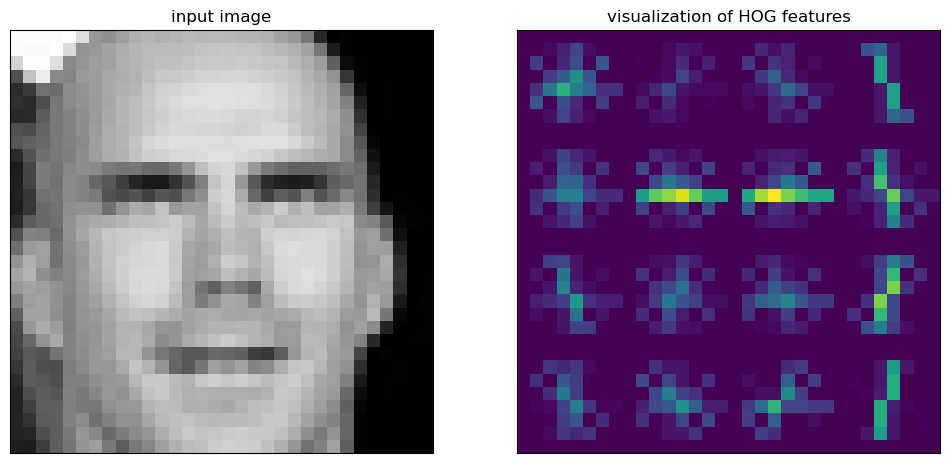

In [8]:
bw_img_wiev_with_hog(faces[90]) #print an example of positive sample with its HOG features

**Importing negative samples - The NON faces**

Among the different sources found, I choose the *CIFAR 100 dataset* (https://www.cs.toronto.edu/~kriz/cifar.html) for the negative samples, as it looks like the most complete and ready to use image dataset. As negative samples, I try to include different kind of images: animals, outdoor scenes, man-made things, vehicles. And, of course, **not** people.

The images' size is 32x32, therefore the positive samples have been sliced in 32x32 shape in the previous steps. I think this size is quite small, but can help since the face detection should work with low computing resources.

In [10]:
#pickle extraction instruction suggested by CIFAR 100 dataset https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [11]:
file = unpickle('cifar-100-python/train')

In [12]:
def reshape_cifar_10_img (array_cifar_10):
    """
    Reshapes correctly an image contained in CIFAR 100 dataset
    """
    l1 = []
    for i in range(1024):
        l2 = [array_cifar_10[i], array_cifar_10[i+1024], array_cifar_10[i+2048]]
        l1.append(l2)
    return color.rgb2gray(np.reshape(np.array(l1), (32,32,3)))

In [13]:
def reshape_cifar_10_data (data_cifar_10):
    """
    Creates the array of reshaped images of CIFAR 100 dataset
    """
    l = []
    for i in range(data_cifar_10.shape[0]):
        l.append(reshape_cifar_10_img(data_cifar_10[i]))
    return np.array(l)

In [14]:
non_faces = reshape_cifar_10_data(file[b'data']) #extraction of negative samples, including the whole CIFAR 100 dataset

In [15]:
non_faces.shape

(50000, 32, 32)

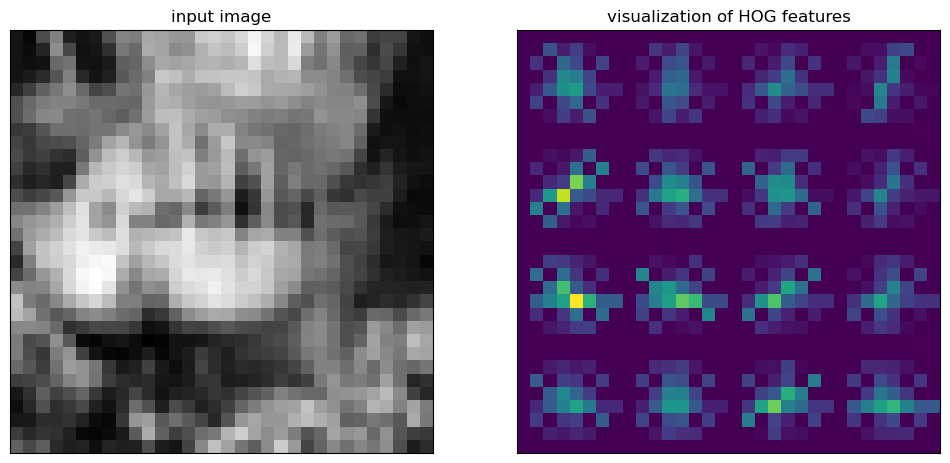

In [16]:
bw_img_wiev_with_hog(non_faces[4]) #print an example of negative sample

In [17]:
#Selecting the CIFAR 100 dataset classes, in order to have 30.0000 negative samples
#Classes excluded: aquatic mammals, household furniture, insects, large carnivores, large natural outdoor scenes, non-insect invertebrates, people, vehicles 2
l = []
for i in range(len(file[b'coarse_labels'])):
    if file[b'coarse_labels'][i] not in [0, 6, 7, 8, 10, 13, 14, 19]:#category labels of excluded classes
        l.append(non_faces[i])

non_faces_samples = np.array(l) #negative samples

In [18]:
non_faces_samples.shape

(30000, 32, 32)

**Assembling the dataset for model fitting**

From both positive and negative samples are now extracted the HOG features, and the resulting data is then merged into a single matrix of arrays of "hogged" images

In [20]:
X_pos = np.array([feature.hog(im) for im in faces])
X_neg = np.array([feature.hog(im) for im in non_faces_samples])
X = np.concatenate((X_pos, X_neg), axis=0)
X.shape

(43233, 324)

In order to fit the model, I create the labels array

In [22]:
y = np.zeros(X.shape[0])
y[:faces.shape[0]] = 1
y.shape

(43233,)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

**Model fitting**

At first, considering the type of training data, the type of classification, and the need of low computing resources, I tried to fit a LinearSVC with Randomized Search CV (see the following cell).

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
import scipy

param_range = scipy.stats.loguniform(0.1, 100)

param_grid = [
    {'C': param_range}]

rs = RandomizedSearchCV(
    estimator=LinearSVC(),
    param_distributions=param_grid,
    scoring='accuracy',
    n_iter=20,
    cv=10,
    random_state=1,
    n_jobs=-1
)
rs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the n

RandomizedSearchCV(cv=10, estimator=LinearSVC(), n_iter=20, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1252dd2d0>}],
                   random_state=1, scoring='accuracy')

In [26]:
rs.best_score_

0.9814951597927525

In [27]:
model = rs.best_estimator_
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.9826070866870201

The LinearSVC had very high accuracy score, but I preferred **Logistic Regression** instead.

With a quick *cross_val_score* on the training set I noticed approximately the same level of accuracy.
Furthermore, LinearSVC model does not have a pivotal method that I need later in the notebook: *predict_proba*.
Logistic Regression lets me get the prediction probability instead.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba

In [29]:
cross_val_score(LogisticRegression(), X_train, y_train)

array([0.97918273, 0.97979954, 0.98087895, 0.97902853, 0.98210981])

In [30]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):
    """
    Plots confusion matrix
    """
    
    cm = confusion_matrix(y_true, y_pred)
    
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='g')
    
    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
        plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")

In [31]:
def model_evaluation (model, X, y, thresh=0.5): #oltre al modello, features e target, anche il valore della threshold è tra i parametri della funzione, default=0.5
    """
    Prints classification report and confusion matrix
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    y_pred = np.where(y_prob[:,1]>thresh,1,0)
    
    
    print('Report')
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(y, y_pred,labels=['No face', 'Face'])

The Logistic Regression model is finally fitted, with great performances on both training and test sets.

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9813409819886504

In [34]:
lr.score(X_test, y_test)

0.9820519937089462

Report
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      7431
         1.0       0.98      0.97      0.97      3378

    accuracy                           0.98     10809
   macro avg       0.98      0.98      0.98     10809
weighted avg       0.98      0.98      0.98     10809



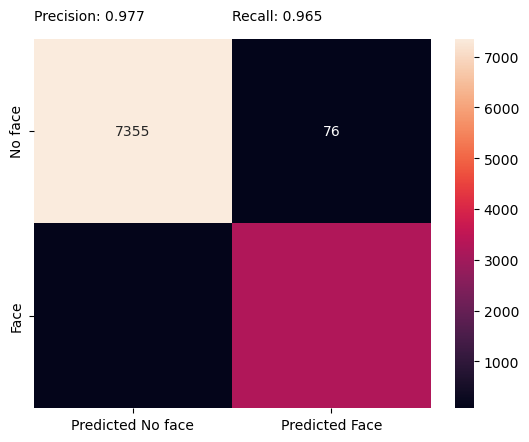

In [35]:
model_evaluation(lr, X_test, y_test)

With a fitted model, I can proceed with the definition of the prediction pipeline and function.

### Face detection

As mentioned previously the goal is to detect one or more faces (if any) in an image.
In order to do so, the given image is sliced in many "patches" of the same size as the images that trained the model (32x32).
This is done by the following *"sliding window"* function, taken from https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html and adapted.
The patches are saved with the indices of the two for loops of the function, that represent their up-left coordinate.

In [38]:
def sliding_window(img, patch_size=faces[0].shape,
                   istep=2, jstep=2):
    """
    Sliding window function that slices patches of a given images.
    """
    Ni, Nj = (int(s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            yield (i, j), patch

The face detection occurs with a sklearn pipeline that classifies the given image patches "face" or not.
In order to put the HOG features extraction as a pipeline step, I use the useful sklearn *Function Transformer*. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [40]:
def img_hog(patches):
    """
    Extracts HOG features from a given image
    """
    patches_hog = np.array([feature.hog(patch) for patch in patches])
    return patches_hog

In [41]:
img_hog_transformer = FunctionTransformer(img_hog)#the hog extraction function can be used as a pipeline transformer

In [42]:
pipe_face = Pipeline(
    steps=[
        ('hog', img_hog_transformer),
        ('clf', lr)
    ]
)

The pipeline is included in a function that completes the detection process.
The function is commented **step-by-step** in the following cell.

In [44]:
def face_detection (img_path):
    #saves image as array, with numpy and PIL library
    img = np.asarray(Image.open(img_path))
    #converts image in gray-scale with scikit-image tool
    img_bw = skimage.color.rgb2gray(img)
    #with scikit-image tool, proportionally resize the image to a fixed 100 pixel height, in order to lighten the computation
    #after several attempts, I think 100 pixel height is a functional height for a 32x32 face patch. Faces usually cover 1/3 of the vertical size of the image in a selfie
    #furthermore, a focus on the "rule of thirds" of portrait photography leads me to think that this 1 to 3 proportion could approximate well the different possible shots to predict
    #https://www.adobe.com/uk/creativecloud/photography/discover/rule-of-thirds.html#:~:text=The%20rule%20of%20thirds%20is%20applied%20to%20portrait%20photography%20in,a%20rule%20of%20thirds%20grid.
    #https://bidunart.com/rule-of-thirds-in-portrait-photography/
    img_rs = skimage.transform.rescale(img_bw, 100/img_bw.shape[0])
    #calls the sliding window function and saves the up-left coordinates in indices and all the patches in patches
    #these steps could have been added to the pipeline too, but the variable indices is needed later, outside the pipeline
    indices, patches = zip(*sliding_window(img_rs))
    indices = np.array(indices)
    #calls the predict method of the pipeline and save labels
    labels = pipe_face.predict(patches)
    #saves predicted probabilities
    labels_proba = pipe_face.predict_proba(patches)
    
    #initialize list where bounding boxes will be saved
    best_sq = []
    
    #if there are no positive labels, 0 faces have been detected, therefore an empty list will be returned
    if labels.sum() > 0:
        labels_proba_pos = []
        #saves the predicted probabilities of positive class (face)
        for i in range(len(labels)):
            labels_proba_pos.append(labels_proba[i][1])
        labels_proba_pos = np.array(labels_proba_pos)
        
        #saves the up-left coordinates of those positive patches with a predicted probability over 80%
        sq_points = []
        for i, j in indices[labels_proba_pos > 0.8]:#after several attempts, I set the 80% threshold in order to reduce false positive
            sq_points.append([i,j])
        sq_points=np.array(sq_points)
        
        #if no coordinates have been saved in the list, there are 0 positive prediction with enough confidence, therefore an empty list will be returned
        if len(sq_points)>0:
            
            #for each face in the given image, there could be many patches. The DBSCAN clustering groups the patches by person
            #the model takes the up-left coordinate couples and checks the distance among them.
            #After several attempts, I chose 16 as a distance parameter, in order to assign all the similar patches to the same class (person), but also assign possible nearby faces to a different class
            #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
            #the goal is to save the patch with the maximum predicted probability, for each class (person)
            clustering = DBSCAN(eps=16, min_samples=1).fit(sq_points)
            
            #saves the predicted probabilities of the positive predictions with enough confidence
            sq_point_prob_pos = []
            for p in labels_proba_pos[labels_proba_pos > 0.8]:
                sq_point_prob_pos.append(p)
            sq_point_prob_pos = np.array(sq_point_prob_pos)
            
            #for each clustering class, saves the coordinates with the max predicted probability, and its class
            #the result is a list with index, coordinates, and probability for each face detected
            for c in np.unique(clustering.labels_):
                best_prob = np.max(sq_point_prob_pos[clustering.labels_==c])
                best_points = sq_points[sq_point_prob_pos==best_prob]
                best_sq.append([c, best_points, best_prob])
    return best_sq

In [45]:
def draw_box (img_path, bbox):
    """
    Prints given image in its original size. If one or more faces are detected, it prints the faces bounding boxes.
    ratio adapts bounding boxes sizes to the image in original size.
    """
    img = np.asarray(Image.open(img_path))
    
    ratio = 100/img.shape[0]
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    if len(bbox)>0:
        Ni, Nj = faces[0].shape
        
        for i in range(len(bbox)):
            ax.add_patch(plt.Rectangle((int(bbox[i][1][0][1]/ratio), int(bbox[i][1][0][0]/ratio)), int(Nj/ratio), int(Ni/ratio), edgecolor='red',
                                       alpha=0.3, lw=2, facecolor='none'))
    
    return

### Test

After testing the face detection function on selfies and images found online, the results are quite satisfying.

In the following 3 images, the face is well detected:

[[0, array([[22, 58]]), 0.9992829812767449]]


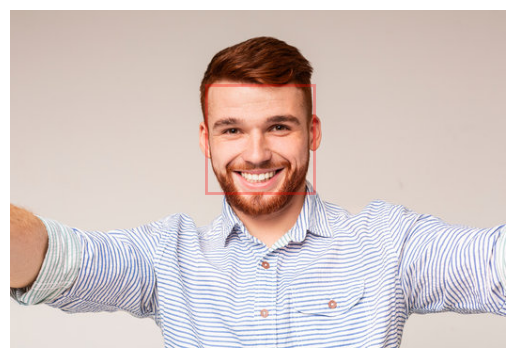

In [48]:
draw_box('selfies/01.jpeg', face_detection('selfies/01.jpeg'))
print(face_detection('selfies/01.jpeg'))

[[0, array([[20, 70]]), 0.9995321469317395]]


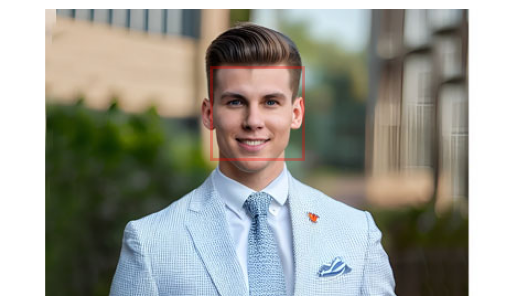

In [49]:
draw_box('selfies/02.jpeg', face_detection('selfies/02.jpeg'))
print(face_detection('selfies/02.jpeg'))

[[0, array([[24, 94]]), 0.8336120428409832]]


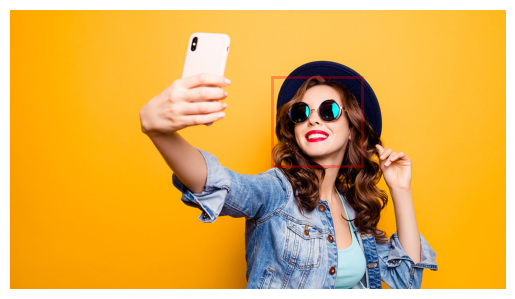

In [50]:
draw_box('selfies/03.jpg', face_detection('selfies/03.jpg'))
print(face_detection('selfies/03.jpg'))

The following 2 images do not contain faces.
However, a *false positive* is detected in the city image, with a probability just above the threshold.

[[0, array([[64, 24]]), 0.8083557122810479]]


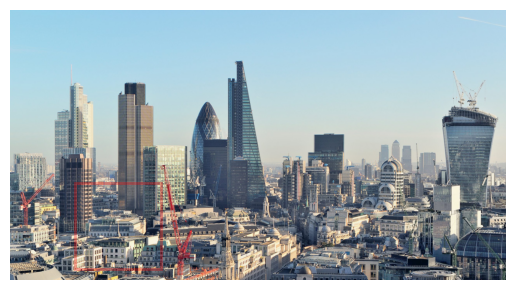

In [52]:
draw_box('selfies/city.jpeg', face_detection('selfies/city.jpeg'))
print(face_detection('selfies/city.jpeg'))

[]


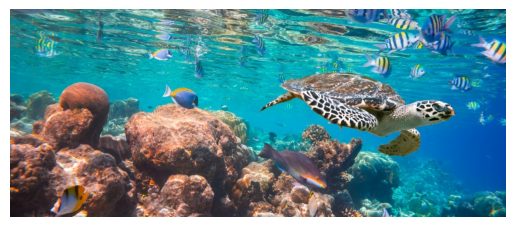

In [53]:
draw_box('selfies/sea.jpeg', face_detection('selfies/sea.jpeg'))
print(face_detection('selfies/sea.jpeg'))

The function detects 4 faces in the famous *"Oscars selfie"*

[[0, array([[10, 16]]), 0.921660413277872], [1, array([[ 26, 126]]), 0.9809626513607655], [2, array([[40, 54]]), 0.974026163299504], [3, array([[56, 94]]), 0.9540232628715665]]


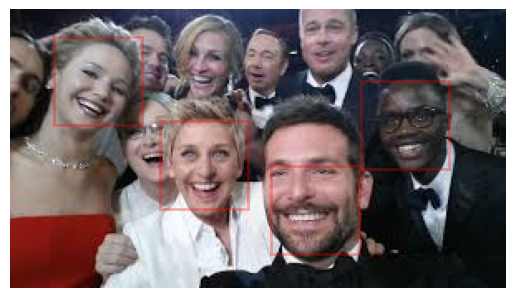

In [55]:
draw_box('selfies/oscarselfie.jpeg', face_detection('selfies/oscarselfie.jpeg'))
print(face_detection('selfies/oscarselfie.jpeg'))